## Problem:
Describe a persona [classify] of wether the next patient that is administered basic laboratory tests would require to be admitted in to the hospital (incare patient) or can be treated within the out-patient department of the hospital itself.

## Aims and Methods: 
For this classification we aim to test a suite of supervisory classification algorithms, namely:
1. Logistic Regression
2. Support Vector Machine
3. K-Nearest Neighbour
4. Random Forest

We will use the **'SOURCE'** column that classifies each patient as **'IN'** or **'OUT'** as the target variable for the classification process.

## Data Collection:
Dataset used is the Electronic Health Record (EHC) obtained from a private hospital in Indonesia. It contains the patients laboratory test results.

## Exploratory Data Analysis:

In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from scipy.stats import shapiro, mstats, jarque_bera
sns.set()

# For pltoly graphs
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, accuracy_score

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load the Data:

In [2]:
data  = pd.read_csv('data-ori.csv')
data.tail(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,in
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,in
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,out
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,in
4411,33.5,10.9,3.44,5.8,275,31.7,32.5,97.4,99,F,out


In [3]:
# Set Encoding labels for the target variable 'SORUCE'
data['SOURCE'] = data['SOURCE'].replace({'in': 1, 'out': 0})

# List all the features of the dataset
features = [col for col in data.columns if col != 'SOURCE']

#List the categorical and numerical features
num_feats = [numf for numf in features if data[numf].dtype != object]
cat_feats = [catf for catf in features if data[catf].dtype == object]
print(f'The feature table contains:\n1. {len(num_feats)} numerical feature[s] -', end=' ')
print(*num_feats, sep=', ')
print(f'2. {len(cat_feats)} categorical feature[s] -', end=' ')
print(*cat_feats)

The feature table contains:
1. 9 numerical feature[s] - HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCH, MCHC, MCV, AGE
2. 1 categorical feature[s] - SEX


# Exploratory Data Analysis (EDA)

### Features in dataset:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4412 entries, 0 to 4411
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   4412 non-null   float64
 1   HAEMOGLOBINS  4412 non-null   float64
 2   ERYTHROCYTE   4412 non-null   float64
 3   LEUCOCYTE     4412 non-null   float64
 4   THROMBOCYTE   4412 non-null   int64  
 5   MCH           4412 non-null   float64
 6   MCHC          4412 non-null   float64
 7   MCV           4412 non-null   float64
 8   AGE           4412 non-null   int64  
 9   SEX           4412 non-null   object 
 10  SOURCE        4412 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 379.3+ KB


* The dataset does not contain any missing/null values.
* For the feature list we can again see that the categorical varriable is 'SEX' as indicated by the 'object' data type.

In [5]:
# Unique values for each feature and target variables

data.nunique().to_frame('Unqiue Values')

,Unqiue Values
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


### Descriptive Statistics:

In [6]:
data.describe(include='all')

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412,4412.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2290,NaN
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473,NaN,0.404352
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218,NaN,0.490822
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000,NaN,0.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000,NaN,0.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000,NaN,0.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000,NaN,1.000000


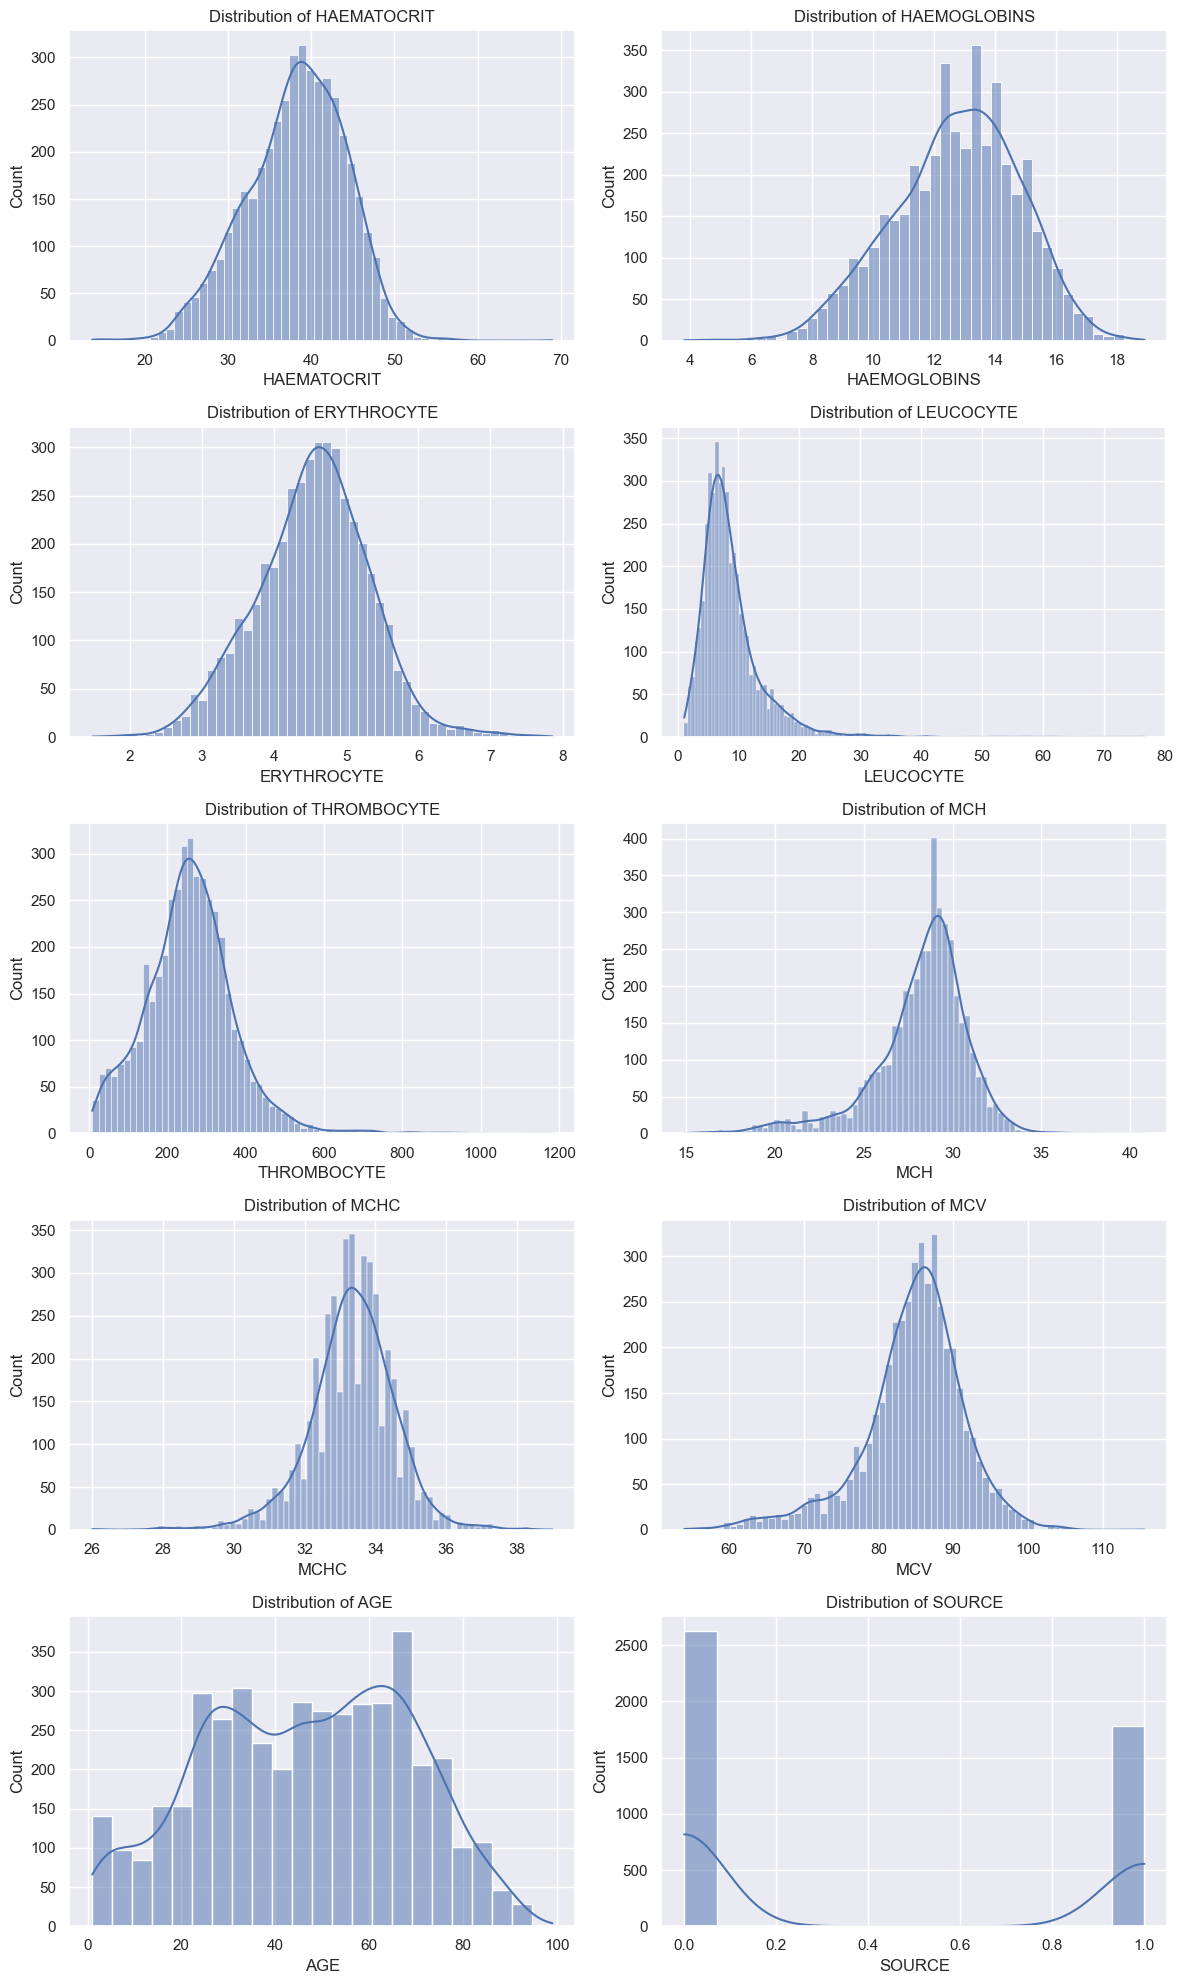

In [7]:
# Distribution of variables
numeric_columns = data.select_dtypes(include=[np.number]).columns
num_vars = len(numeric_columns)

# Calculate the number of rows needed in the subplot grid (2 columns grid here for more horizontal space)
num_rows = (num_vars + 1) // 2

plt.figure(figsize=(12, num_rows * 4))  # Adjust the figure size based on the number of rows
for i, col in enumerate(numeric_columns):
    plt.subplot(num_rows, 2, i + 1)  # 2 columns
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Normalization

Shapiro-Wilk Test/Jarque-Bera Test

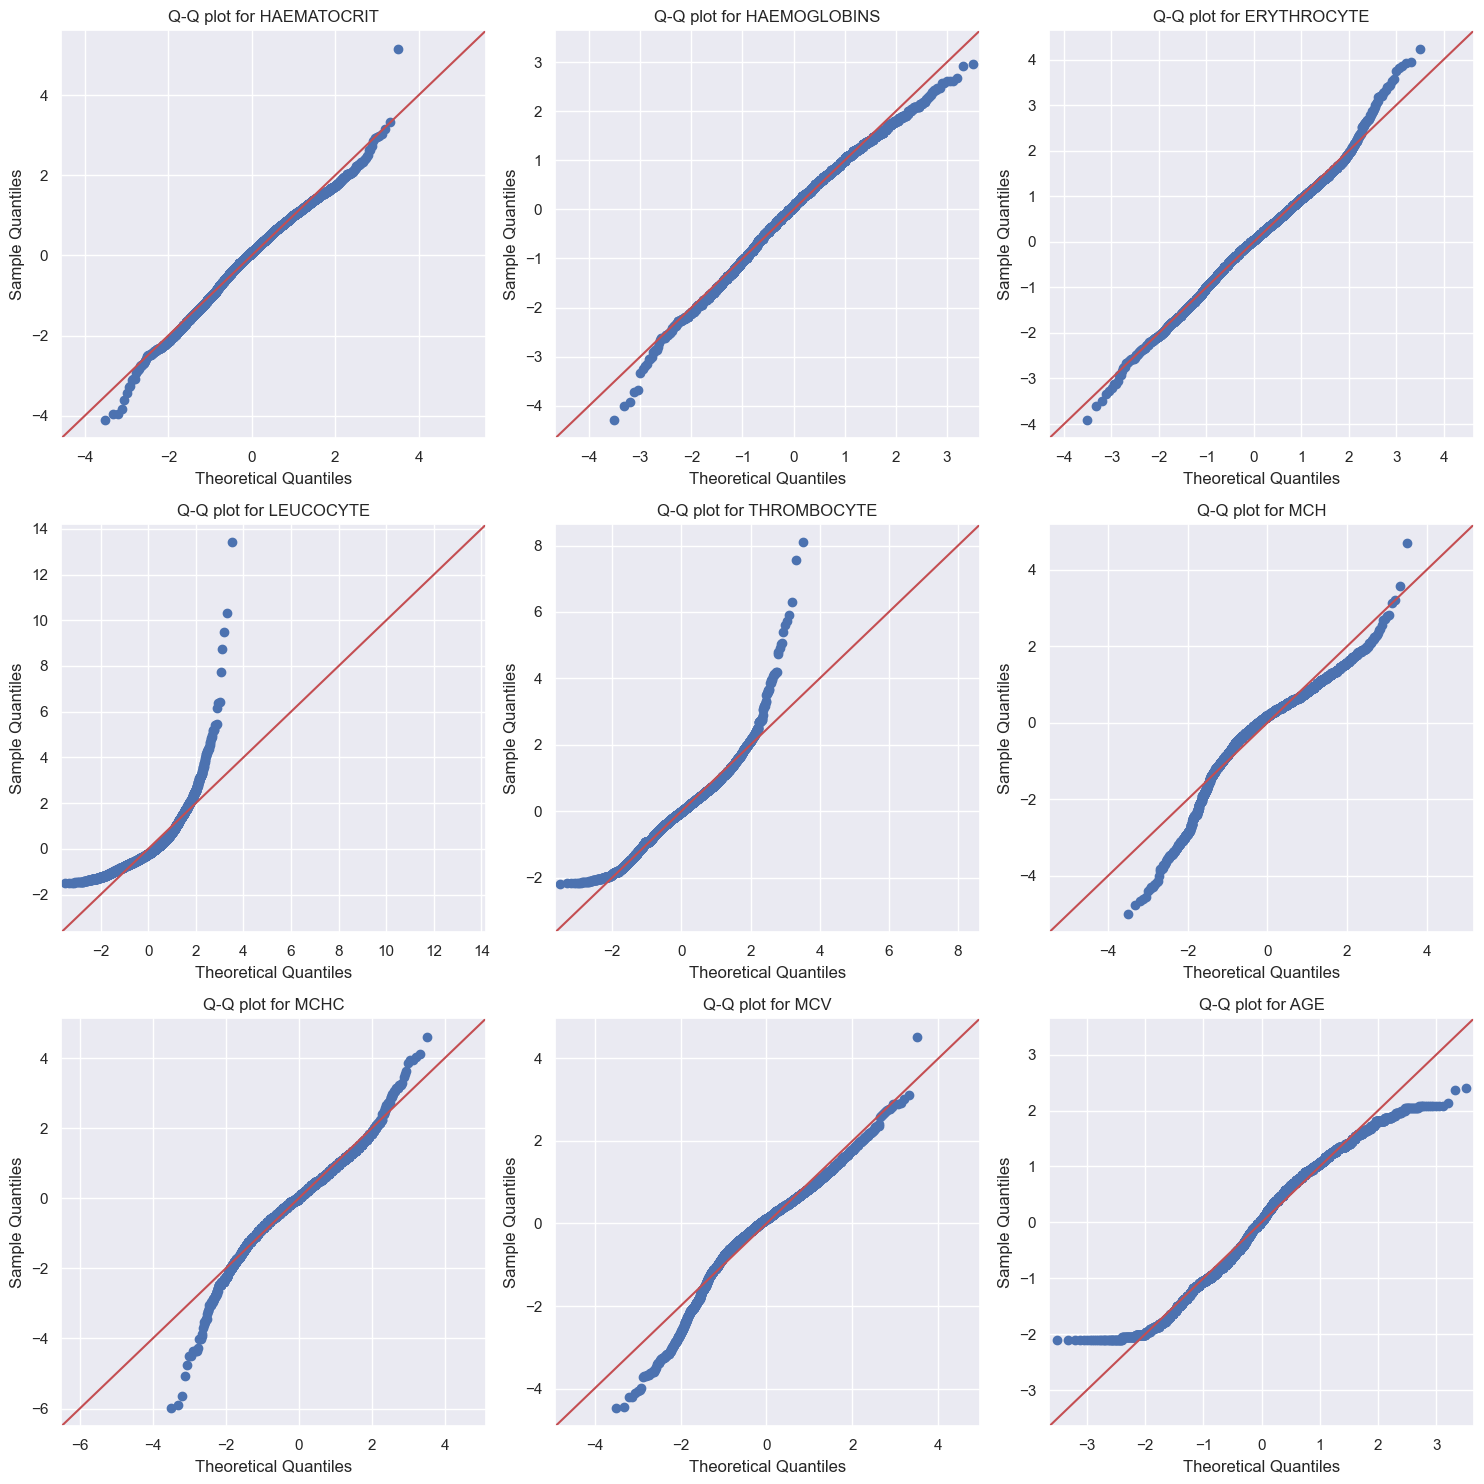

                 Statistic        p-value
HAEMATOCRIT      70.846333   4.129659e-16
HAEMOGLOBINS     72.505472   1.801511e-16
ERYTHROCYTE      50.636894   1.010039e-11
LEUCOCYTE     63461.523424   0.000000e+00
THROMBOCYTE    3364.988832   0.000000e+00
MCH            2292.628795   0.000000e+00
MCHC           1366.448760  1.902926e-297
MCV            1079.133683  4.667649e-235
AGE             141.057522   2.342870e-31


In [8]:
# Assume df_robust is your DataFrame with robust scaling applied to the necessary columns
numeric_cols = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

# Initialize a dictionary to store test results
normality_results = {}

# Determine the grid size for subplots
n_cols = 3  # Number of columns in the grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Calculate rows needed, rounded up

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each column to plot
for i, column in enumerate(numeric_cols):
    # Perform Jarque-Bera test
    stat, p = jarque_bera(data[column])
    normality_results[column] = {'Statistic': stat, 'p-value': p}

    # Plot Q-Q plot in the respective subplot
    sm.qqplot(data[column], line='45', fit=True, ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {column}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Hide any unused subplots if the number of plots isn't a perfect fit for the grid
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

# Show the plot grid
plt.show()
# Convert results to a DataFrame for better visualization
normality_test_df = pd.DataFrame(normality_results).T  # Transpose to have columns as headers
print(normality_test_df)

As can be seen above, all variables are not normalized so we need normalization.

Solve long tail issues:

In [9]:
# # Log Transformation (add 1 to shift all values away from zero)
# data['LEUCOCYTE_log'] = np.log1p(data['LEUCOCYTE'])

# # Winsorizing the data (limiting extreme values to the 95th percentile)
# data['LEUCOCYTE_winsorized'] = mstats.winsorize(data['LEUCOCYTE'], limits=[0, 0.10])

In [10]:
# Log Transformation (add 1 to shift all values away from zero)
data['LEUCOCYTE'] = np.log1p(data['LEUCOCYTE'])
# Winsorizing the data (limiting extreme values to the 95th percentile)
data['LEUCOCYTE'] = mstats.winsorize(data['LEUCOCYTE'], limits=[0, 0.10])

In [11]:
# Log Transformation (add 1 to shift all values away from zero)
data['THROMBOCYTE'] = np.log1p(data['THROMBOCYTE'])
# Winsorizing the data (limiting extreme values to the 95th percentile)
data['THROMBOCYTE'] = mstats.winsorize(data['THROMBOCYTE'], limits=[0, 0.05])

In [12]:
data

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,1.987874,5.739793,25.4,33.6,75.5,1,F,0
1,43.5,14.8,5.39,2.617396,5.814131,27.5,34.0,80.7,1,F,0
2,33.5,11.3,4.74,2.653242,5.723585,23.8,33.7,70.7,1,F,0
3,39.1,13.7,4.98,2.442347,5.905362,27.5,35.0,78.5,1,F,0
4,30.9,9.9,4.23,2.760010,5.811141,23.4,32.0,73.0,1,M,0
...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,2.208274,4.290459,29.8,31.7,94.0,92,F,1
4408,33.7,10.8,3.67,2.041220,4.262680,29.4,32.0,91.8,92,F,1
4409,33.2,11.2,3.47,2.104134,5.463832,32.3,33.7,95.7,93,F,0
4410,31.5,10.4,3.15,2.312535,5.236442,33.0,33.0,100.0,98,F,1


In [13]:
# Select numeric columns (excluding categorical columns like 'SEX' and 'SOURCE')
# numeric_cols = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE_winsorized', 'THROMBOCYTE_winsorized', 'MCH', 'MCHC', 'MCV', 'AGE']
numeric_cols = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

# # Min-Max Scaling
# min_max_scaler = MinMaxScaler()
# df_min_max = data.copy()
# df_min_max[numeric_cols] = min_max_scaler.fit_transform(data[numeric_cols])

# Z-score Normalization
standard_scaler = StandardScaler()
df_standard = data.copy()
df_standard[numeric_cols] = standard_scaler.fit_transform(data[numeric_cols])

# Robust Scaling
robust_scaler = RobustScaler()
df_robust = data.copy()
df_robust[numeric_cols] = robust_scaler.fit_transform(data[numeric_cols])

KeyError: "['LEUCOCYTE_log', 'THROMBOCYTE_log'] not in index"

In [ ]:
numeric_cols

['HAEMATOCRIT',
 'HAEMOGLOBINS',
 'ERYTHROCYTE',
 'LEUCOCYTE_log',
 'THROMBOCYTE_log',
 'MCH',
 'MCHC',
 'MCV',
 'AGE']

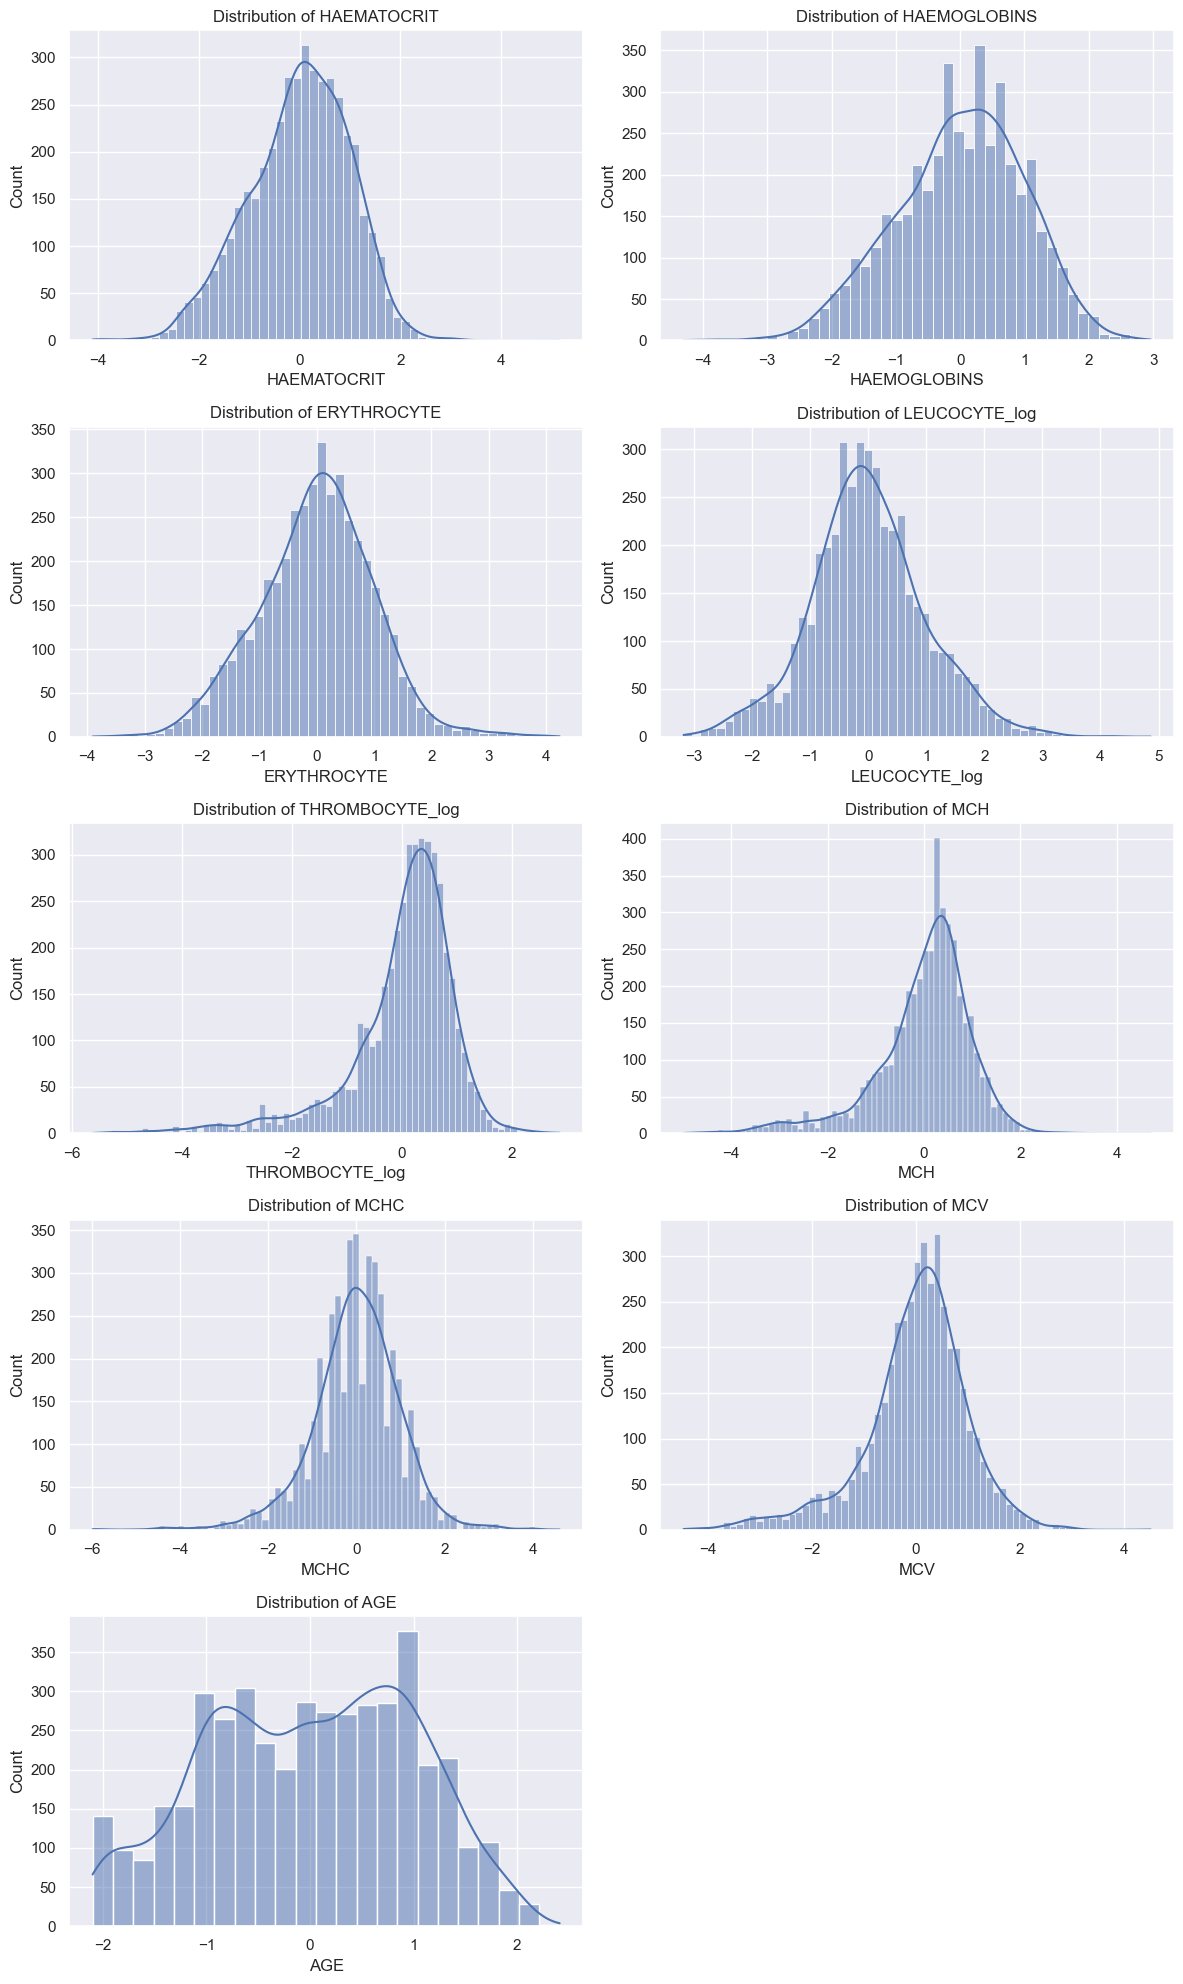

In [ ]:
# Distribution of variables
num_vars = len(numeric_cols)

# Calculate the number of rows needed in the subplot grid (2 columns grid here for more horizontal space)
num_rows = (num_vars + 1) // 2

plt.figure(figsize=(12, num_rows * 4))  # Adjust the figure size based on the number of rows
for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, 2, i + 1)  # 2 columns
    sns.histplot(df_standard[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

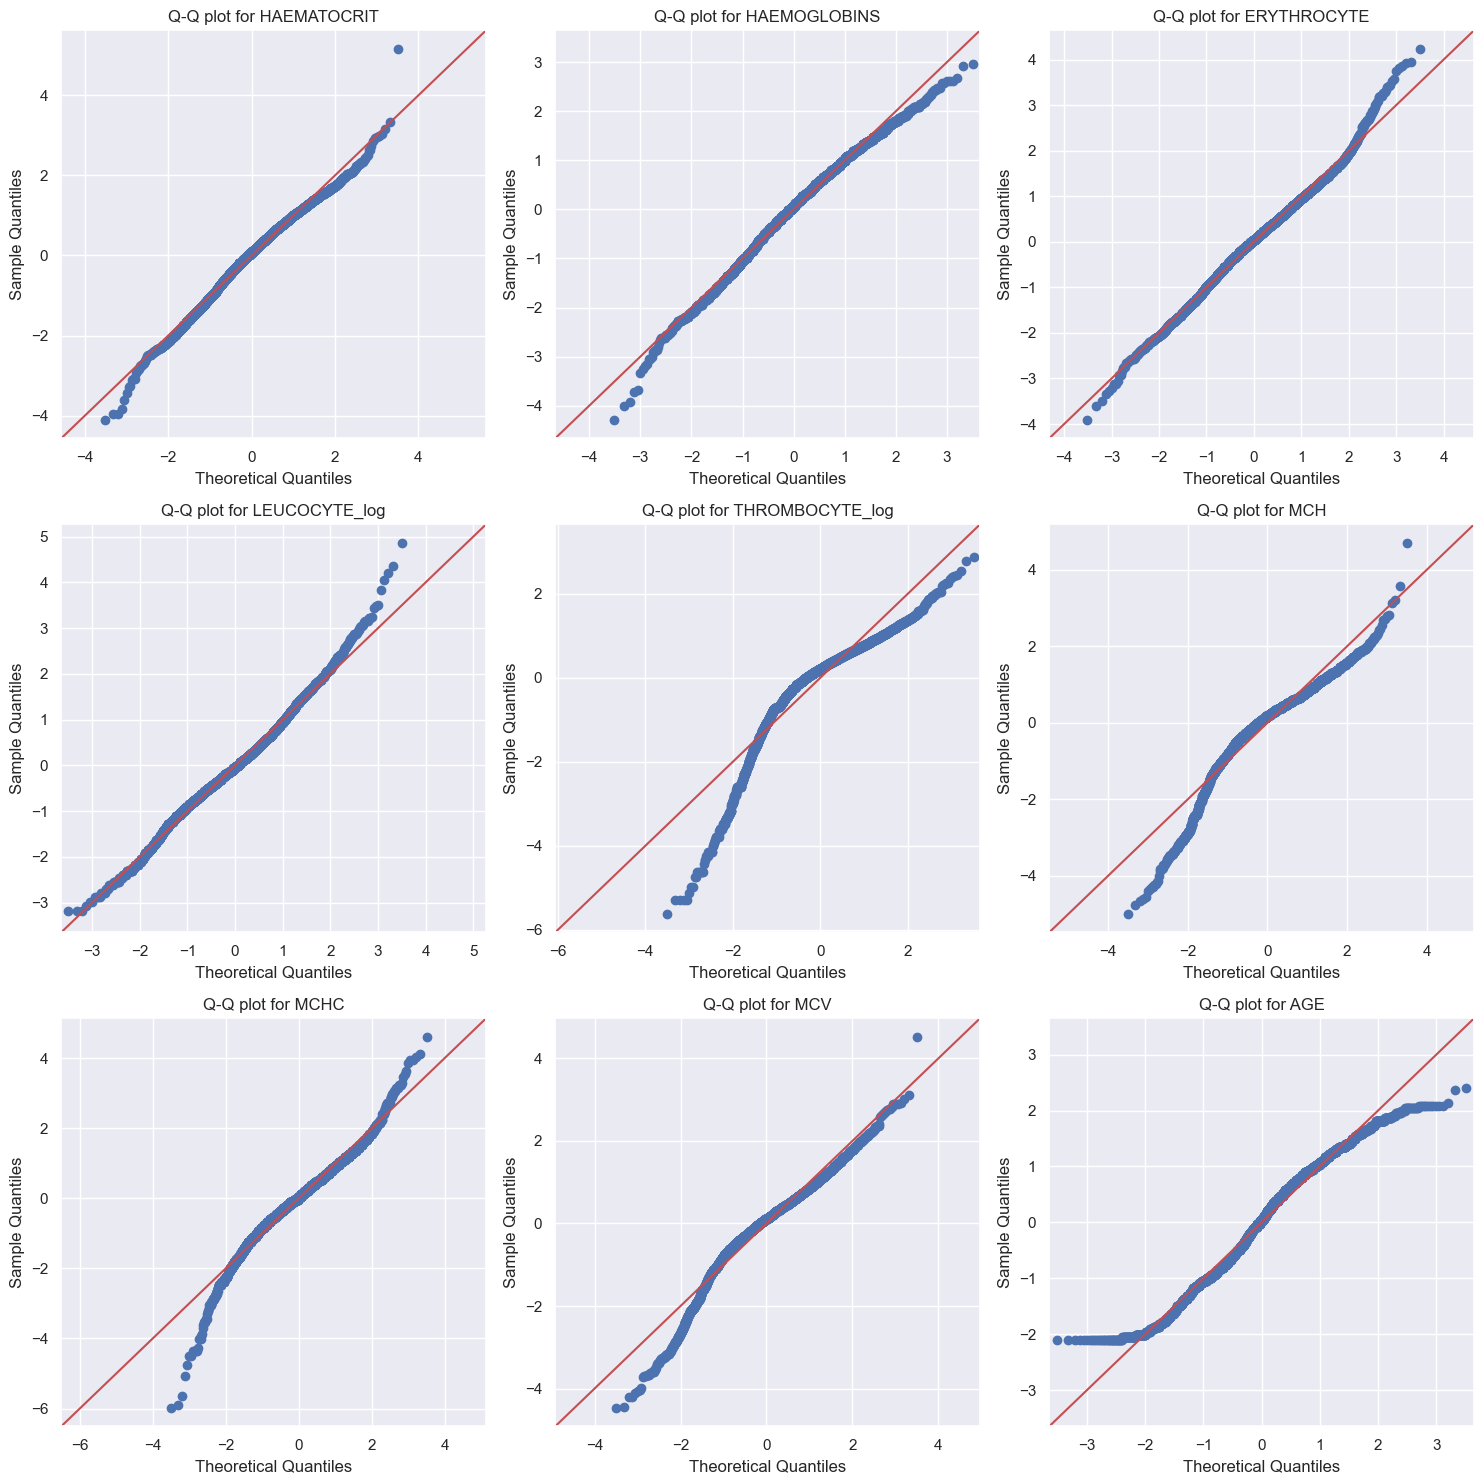

                   Statistic        p-value
HAEMATOCRIT        70.846333   4.129659e-16
HAEMOGLOBINS       72.505472   1.801511e-16
ERYTHROCYTE        50.636894   1.010039e-11
LEUCOCYTE_log     116.403108   5.289154e-26
THROMBOCYTE_log  5747.061476   0.000000e+00
MCH              2292.628795   0.000000e+00
MCHC             1366.448760  1.902926e-297
MCV              1079.133683  4.667649e-235
AGE               141.057522   2.342870e-31


In [ ]:
# Initialize a dictionary to store test results
normality_results = {}

# Determine the grid size for subplots
n_cols = 3  # Number of columns in the grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Calculate rows needed, rounded up

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each column to plot
for i, column in enumerate(numeric_cols):
    # Perform Jarque-Bera test
    stat, p = jarque_bera(df_standard[column])
    normality_results[column] = {'Statistic': stat, 'p-value': p}

    # Plot Q-Q plot in the respective subplot
    sm.qqplot(df_standard[column], line='45', fit=True, ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {column}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Hide any unused subplots if the number of plots isn't a perfect fit for the grid
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

# Show the plot grid
plt.show()

# Convert results to a DataFrame for better visualization
normality_test_df = pd.DataFrame(normality_results).T  # Transpose to have columns as headers

print(normality_test_df)

In [ ]:
data

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE,LEUCOCYTE_log,LEUCOCYTE_winsorized,THROMBOCYTE_log,THROMBOCYTE_winsorized
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,0,1.987874,6.3,5.739793,310
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,0,2.617396,12.7,5.814131,334
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,0,2.653242,13.2,5.723585,305
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,0,2.442347,10.5,5.905362,366
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,0,3.139833,14.8,5.811141,333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,1,2.208274,8.1,4.290459,72
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,1,2.041220,6.7,4.262680,70
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,0,2.104134,7.2,5.463832,235
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,1,2.312535,9.1,5.236442,187


### Univariate Analysis
Exploring each feature of the dataset

#### Target Variable
* **name:** 'SOURCE'
* **classes:** {'in': 1, 'out': 0}

In [ ]:
fig = px.histogram(data, x='SOURCE')
fig.show()

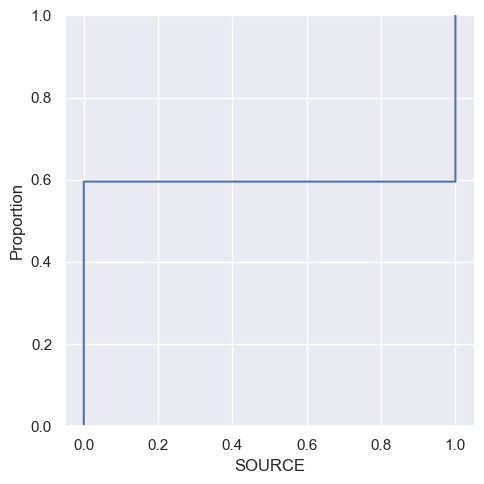

In [ ]:
sns.displot(data['SOURCE'], kind='ecdf', stat='proportion')

* The proportion of classes is about 60:40 which is only mildy imbalanced and won't greatly bias the classification

### Numerical Features

* HAEMATOCRIT
* HAEMOGLOBINS
* ERYTHROCYTE
* LEUCOCYTE
* THROMBOCYTE
* MCH
* MCHC
* MCV
* AGE

In [ ]:
data[num_feats].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


Based on the descriptions of each of the feature variables, a few peculiar values are in:
* **LEUCOCYTE** - max value is much higher than the mean value
* **THROMBOCYTE** - max and min values are very dispersed

In [ ]:
for column in num_feats:
    # Clean and convert data
    clean_data = data[column].dropna()  # Drop NaN values
    clean_data = pd.to_numeric(clean_data, errors='coerce')  # Coerce errors turns any remaining non-numeric values to NaN
    clean_data = clean_data.dropna()  # Drop any new NaNs that were introduced

    # Check if clean_data is empty
    if clean_data.empty:
        print(f"Skipping {column} due to insufficient data after cleaning.")
        continue
    
    fig = make_subplots(rows=1, cols=2)
    
    # Box plot
    fig.add_trace(
        go.Box(y=clean_data, name=column),
        row=1, col=1
    )
    
    # KDE plot
    hist_data = [clean_data]
    group_labels = [column]
    distplot = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
    for trace in distplot.data:
        fig.add_trace(trace, row=1, col=2)
    
    fig.update_layout(title=f"Analysis of {column}")
    fig.show()

In [ ]:
data.loc[data['LEUCOCYTE']==76.6]

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE,LEUCOCYTE_log,LEUCOCYTE_winsorized,THROMBOCYTE_log,THROMBOCYTE_winsorized
3654,27.0,8.8,3.24,76.6,300,27.2,32.6,83.3,69,M,1,4.351567,14.8,5.70711,300


In [ ]:
data.loc[data['THROMBOCYTE']==1183]

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE,LEUCOCYTE_log,LEUCOCYTE_winsorized,THROMBOCYTE_log,THROMBOCYTE_winsorized
3777,43.5,13.7,4.53,17.9,1183,30.2,31.5,96.0,71,F,0,2.939162,14.8,7.076654,439


* Most of the features follow an almost normal distribution with the exception of the LEUCOCYTE, THROMBOCYTE, and and AGE features.
* After inspecting the extreme values in 'LEUCOCYTE' and 'THROMBOCYTE' I have decided to keep them as the other values seem fine as this extreme values could be attributed to the reason they were visiting the hospital.

### Categorical Variable:

* **name**: SEX
* **classes**: F, M 

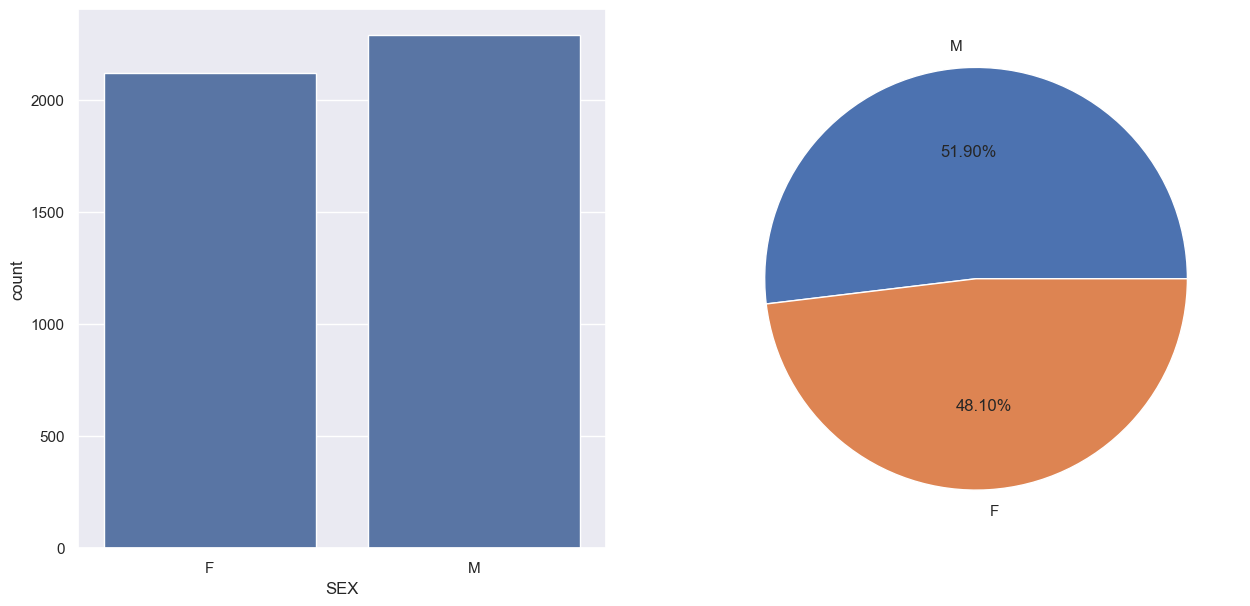

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.countplot(data, x='SEX', ax=ax[0])
plt.pie(data['SEX'].value_counts(), autopct='%0.2f%%', labels=['M', 'F'])
plt.show()

In [ ]:
data['SEX'].value_counts()

M    2290
F    2122
Name: SEX, dtype: int64

### Bivariate Analysis:

In [ ]:
data

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE,LEUCOCYTE_log,LEUCOCYTE_winsorized,THROMBOCYTE_log,THROMBOCYTE_winsorized
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,0,1.987874,6.3,5.739793,310
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,0,2.617396,12.7,5.814131,334
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,0,2.653242,13.2,5.723585,305
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,0,2.442347,10.5,5.905362,366
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,0,3.139833,14.8,5.811141,333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,1,2.208274,8.1,4.290459,72
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,1,2.041220,6.7,4.262680,70
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,0,2.104134,7.2,5.463832,235
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,1,2.312535,9.1,5.236442,187


In [ ]:
num_feats

['HAEMATOCRIT',
 'HAEMOGLOBINS',
 'ERYTHROCYTE',
 'LEUCOCYTE',
 'THROMBOCYTE',
 'MCH',
 'MCHC',
 'MCV',
 'AGE']

HAEMATOCRIT
HAEMOGLOBINS
ERYTHROCYTE
LEUCOCYTE
THROMBOCYTE
MCH
MCHC
MCV
AGE
LEUCOCYTE_log
LEUCOCYTE_winsorized
THROMBOCYTE_log
THROMBOCYTE_winsorized


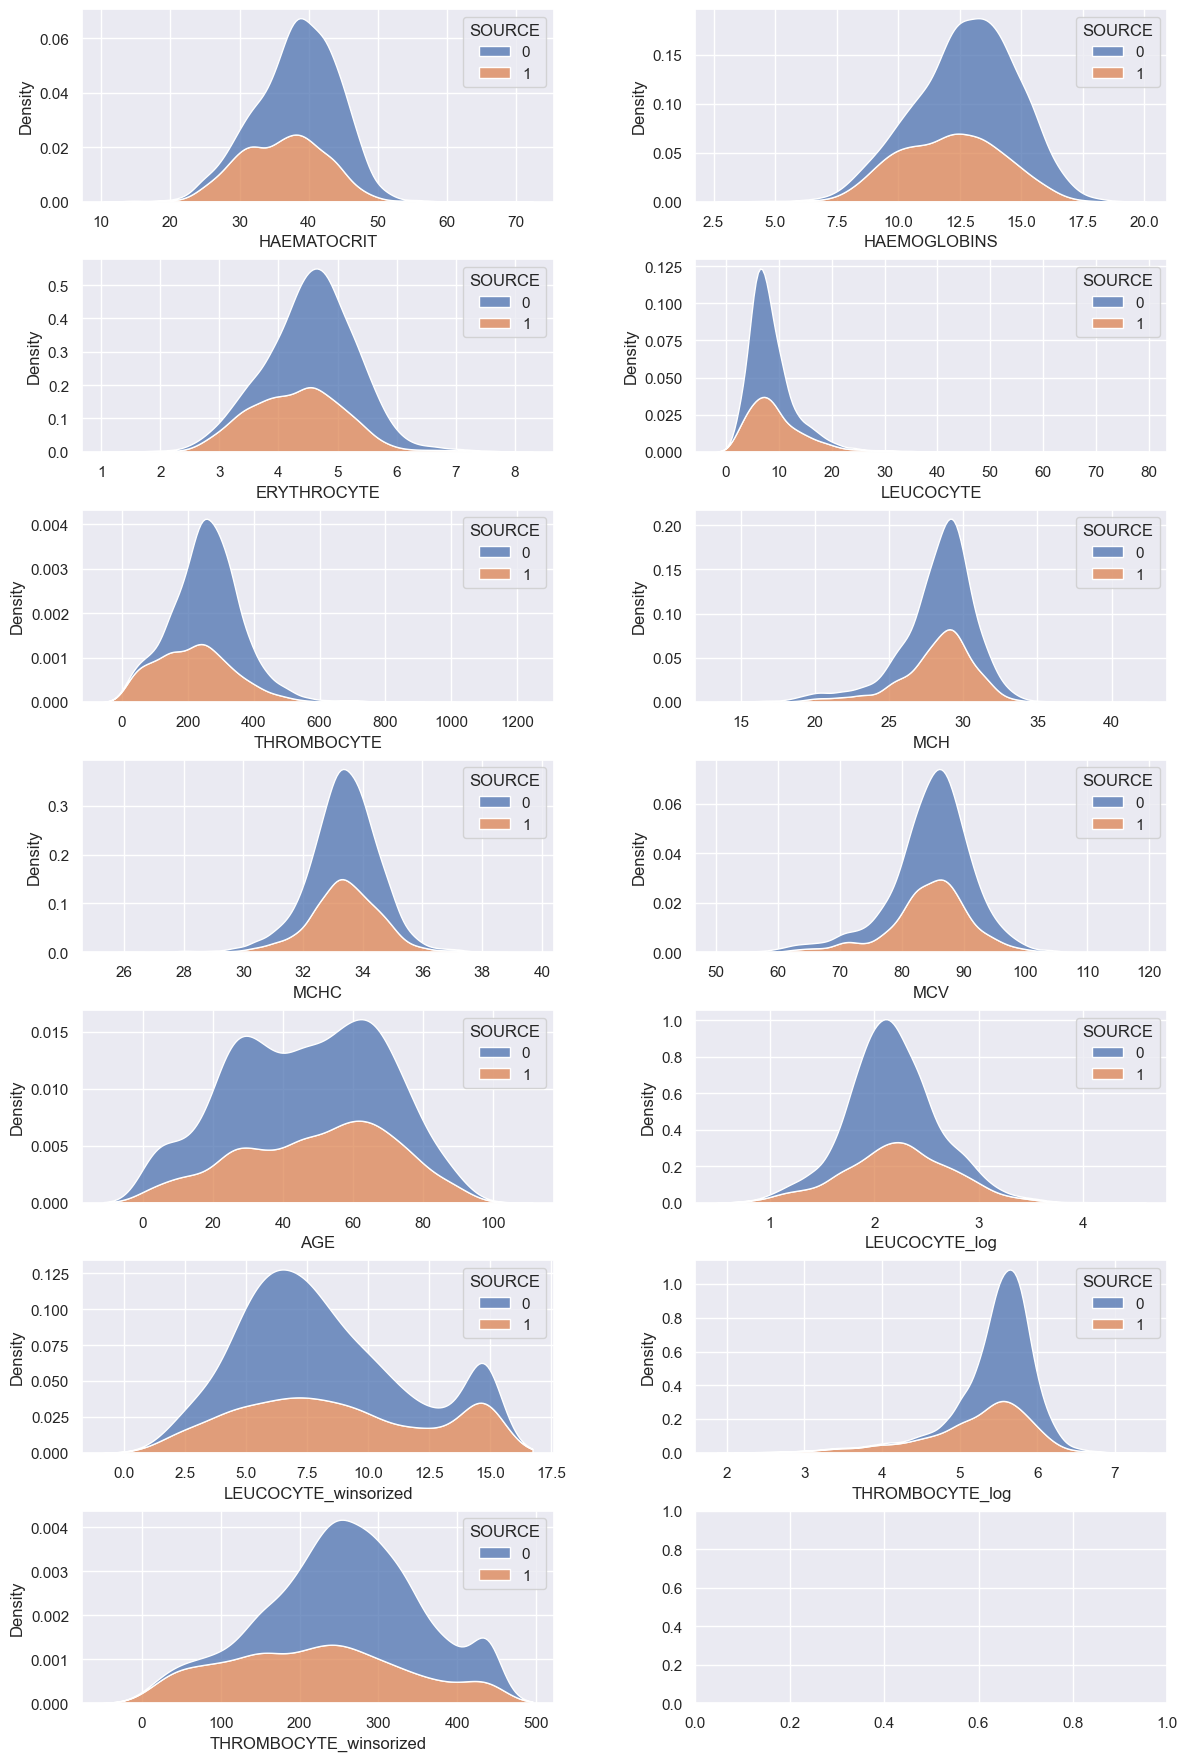

In [ ]:
numeric_features = [feat for feat in data.columns if feat not in ['SEX', 'SOURCE']]

fig, axs = plt.subplots(7, 2, figsize=(14, 22))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [ax for rows in axs for ax in rows]

# Assuming 'num_feats' contains the list of numeric features you want to plot
for idx, feat in enumerate(numeric_features):
    print(feat)
    sns.kdeplot(data=data, x=feat, hue='SOURCE', multiple='stack', ax=axes[idx])

# # Plot 'SEX' with a count plot on the designated subplot axis
# sns.countplot(data=data, x='SEX', hue='SOURCE', ax=axes[7]) 

* The features HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, THROMBOCYTE, AGE show quite a difference in their distributions between the 'in' and 'out' patients, indicating that they serve as much better differentiators of the target variables than the rest.

* The categorical variables only tell us that there is a slightly higher proportion of males in in-patients than out-patients.

* There is a slightly higher older population that are admitted as in-patients but that would be expected and is not of much an insight for now.

---
## Statistical Tests

### 1. Feature Selection

Check variable independence - correlation analysis: calculate the Pearson correlation coefficient for all pairs of continuous variables.

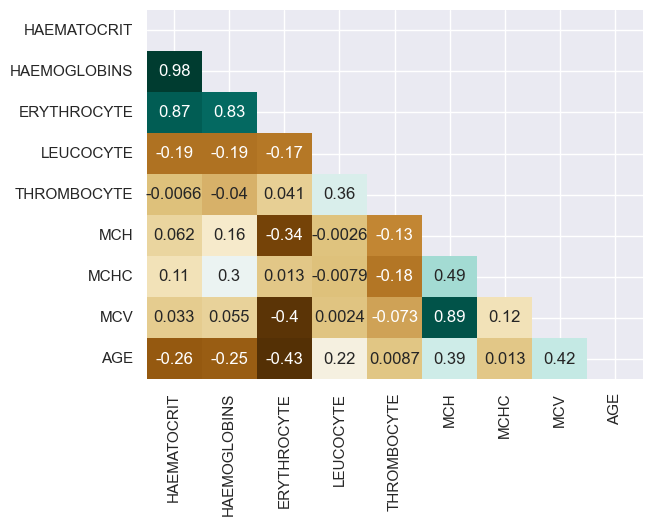

In [ ]:
corr = data[num_feats].corr(method='spearman')
triu_corr = np.triu(corr)
sns.heatmap(corr, annot=True, mask=triu_corr, cmap='BrBG', cbar=False)
plt.show()

* From the pairplots and correlation matrix we can see a high multicollinarity between  'HAEMATOCRIT' and 'HAEMOGLOBINS'(0.98) and  'MCH' and 'MCHC' (0.89). Even 'HAEMATOCRIT' and 'ERYTHROCYTE' (0.87), 'HAEMOGLOBINS' and  'ERYTHROCYTE' (0.83) have a relatively high level of correlation that can lead to overfitting of the model and lead to poor generalization performance on unseen data.

In [ ]:
continuous_vars = data.select_dtypes(include=[float, int])
correlation_matrix = continuous_vars.corr()
print(correlation_matrix)

                        HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  \
HAEMATOCRIT                1.000000      0.973267     0.864989  -0.217218   
HAEMOGLOBINS               0.973267      1.000000     0.818013  -0.208583   
ERYTHROCYTE                0.864989      0.818013     1.000000  -0.186711   
LEUCOCYTE                 -0.217218     -0.208583    -0.186711   1.000000   
THROMBOCYTE               -0.003562     -0.045441     0.025879   0.283262   
MCH                        0.083714      0.203248    -0.383666  -0.014840   
MCHC                       0.108098      0.314159    -0.048313   0.003194   
MCV                        0.054948      0.105379    -0.436041  -0.015885   
AGE                       -0.254799     -0.239480    -0.412858   0.191987   
SOURCE                    -0.271190     -0.255793    -0.232001   0.137359   
LEUCOCYTE_log             -0.197946     -0.192624    -0.174717   0.925336   
LEUCOCYTE_winsorized      -0.199219     -0.192023    -0.171886   0.882756   

Strong Positive Correlations:
HAEMATOCRIT and HAEMOGLOBINS: A correlation of 0.973. 0.973 indicates almost a linear relationship. This is expected since hematocrit is the volume percentage of red blood cells in blood, and hemoglobin is a protein in those cells.
MCH and MCV: A correlation of 0.932. 0.932 suggests that the mean corpuscular hemoglobin (MCH, the average mass of hemoglobin per red blood cell) and the mean corpuscular volume (MCV, the average volume of a red blood cell) are closely linked, which makes sense as both describe properties of red blood cells.
Strong Negative Correlations:


ERYTHROCYTE and MCV: The −0.436. −0.436 correlation indicates that as the erythrocyte count increases, the mean corpuscular volume tends to decrease. This could suggest that higher red blood cell counts are associated with smaller sized cells, potentially pointing to certain microcytic anemias.
AGE and ERYTHROCYTE: A correlation of −0.413. −0.413 may imply that erythrocyte counts tend to decrease with age, which could be relevant in clinical settings.
Moderate to Low Correlations:
LEUCOCYTE and THROMBOCYTE: A correlation of 0.283. 0.283 might suggest a moderate association, indicating possible simultaneous responses to certain conditions like infections or inflammations.
AGE and MCV: The positive correlation of 0.395. 0.395 could indicate changes in red blood cell size with aging.

In [ ]:
# Chi-Square Test of Independence for SEX and SOURCE
contingency_table = pd.crosstab(data['SEX'], data['SOURCE'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 11.626002500279858, p-value: 0.0006503617798734924


Chi-Square Statistic: The Chi-Square statistic of 11.626 suggests that there is a disparity between the observed counts in the categories of SEX and SOURCE and what would be expected if they were independent of each other. A higher Chi-Square value generally indicates a stronger divergence from the null hypothesis of independence.  
p-value: The p-value is a measure of the probability that the observed data (or something more extreme) would occur if the null hypothesis (in this case, the hypothesis that there is no association between SEX and SOURCE) were true. The p-value is 0.0006503617798734924, which is quite low.  

Conclusion:  
Since the p-value is less than 0.05 (a common threshold in statistical testing), we can reject the null hypothesis. This indicates that there is a statistically significant association between the variables SEX and SOURCE.  
In simpler terms, the gender (SEX) of the subjects in our dataset appears to be related to the category of SOURCE. This could mean that whether the SOURCE is "in" or "out" depends to some extent on the gender, or vice versa.  

In [ ]:
# Chi-Square Test of Independence for SEX and SOURCE
contingency_table = pd.crosstab(data['HAEMATOCRIT'], data['HAEMOGLOBINS'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 182515.94615897577, p-value: 0.0


The p-value is very close to zero (0.0), which indicates strong evidence against the null hypothesis. It means that there is a significant association between 'HAEMATOCRIT' and 'HAEMOGLOBINS'.  

The Chi-Square Statistic is considerably high, suggesting a strong association between the two variables.  

In [ ]:
# Chi-Square Test of Independence for SEX and SOURCE
contingency_table = pd.crosstab(data['MCH'], data['MCV'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 271188.93780701736, p-value: 0.0


The p-value is very close to zero (0.0), which indicates strong evidence against the null hypothesis. It means that there is a significant association between 'MCH' and 'MCV'.  

The Chi-Square Statistic is considerably high, suggesting a strong association between the two variables.  

## Drop values

In [ ]:
data = df_standard.drop(columns=['HAEMATOCRIT', 'MCH'])
features = [col for col in data.columns if col != 'SOURCE']
num_feats = [numf for numf in features if data[numf].dtype != object]
cat_feats = [catf for catf in features if data[catf].dtype == object]

### 2. Does the inclusion of certain variables (e.g., AGE, SEX, and HAEMOGLOBINS) significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [ ]:
# Define the models
model1 = sm.OLS.from_formula("SOURCE ~ 1", data=data) # intercept only 
model2 = sm.OLS.from_formula("SOURCE ~ AGE + SEX + HAEMOGLOBINS", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# Perform the likelihood ratio test
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Likelihood Ratio Test:
Test Statistic: 394.3092084217915
p-value: 3.7826754159527335e-85


The test statistic (394.31) indicates that the alternative model (Model 2) is significantly better than the null model (Model 1) in explaining the variation in the dependent variable (SOURCE).  
The p-value (3.78e-85) is extremely small, which means that the probability of observing the test statistic (or a more extreme value) under the null hypothesis is virtually zero.  
Therefore, we can reject the null hypothesis (Model 1) and conclude that the alternative model (Model 2) is a better fit to the data.  
In other words, the inclusion of the additional variables (AGE, SEX, and HAEMATOCRIT) in the alternative model significantly improves the model's ability to explain the variation in SOURCE. This suggests that these variables are important predictors of SOURCE.

### 3. Does the inclusion of certain variables (e.g., ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCHC and MCV) significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [ ]:
# Define the models
model1 = sm.OLS.from_formula("SOURCE ~ AGE + SEX + HAEMOGLOBINS", data=data)
model2 = sm.OLS.from_formula("SOURCE ~ AGE + SEX + HAEMOGLOBINS + ERYTHROCYTE + LEUCOCYTE + THROMBOCYTE + MCHC + MCV", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# Perform the likelihood ratio test
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Likelihood Ratio Test:
Test Statistic: 424.5929945748976
p-value: 1.4813089966106137e-89


In [ ]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SOURCE   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     137.4
Date:                Sun, 05 May 2024   Prob (F-statistic):           4.42e-85
Time:                        15:56:44   Log-Likelihood:                -2922.8
No. Observations:                4412   AIC:                             5854.
Df Residuals:                    4408   BIC:                             5879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3329      0.011     31.699      0.000       0.312       0.353
SEX[T.M]         0.1378      0.015      9.208      0.000       0.108       0.167
AGE              0.0178      0.007      2.431      0.015       0.003       0.032
HAEMOGLOBINS    -0.1425      0.008    -18.513      0.000      -0.158      -0.127
==============================================================================
Omnibus:                    27946.985   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.049
Skew:                           0.368   Prob(JB):                    1.06e-111
Kurtosis:                       1.504   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SOURCE   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     112.2
Date:                Sun, 05 May 2024   Prob (F-statistic):          3.03e-171
Time:                        15:56:44   Log-Likelihood:                -2710.5
No. Observations:                4412   AIC:                             5439.
Df Residuals:                    4403   BIC:                             5497.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5502      0.020     27.205      0.000       0.511       0.590
SEX[T.M]         0.0927      0.015      6.364      0.000       0.064       0.121
AGE              0.0197      0.008      2.493      0.013       0.004       0.035
HAEMOGLOBINS    -0.0211      0.054     -0.392      0.695      -0.127       0.085
ERYTHROCYTE     -0.1148      0.057     -2.029      0.042      -0.226      -0.004
LEUCOCYTE        0.0148      0.001     10.125      0.000       0.012       0.018
THROMBOCYTE     -0.0013    6.4e-05    -19.611      0.000      -0.001      -0.001
MCHC            -0.0100      0.015     -0.683      0.494      -0.039       0.019
MCV             -0.0738      0.028     -2.593      0.010      -0.130      -0.018
==============================================================================
Omnibus:                     1629.669   Durbin-Watson:                   0.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.732
Skew:                           0.400   Prob(JB):                     2.51e-72
Kurtosis:                       1.925   Cond. No.                     3.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-value is extremely close to zero, indicating strong evidence against the null hypothesis. It suggests that the more complex model (model2) provides a significantly better fit to the data compared to the simpler model (model1).  
The Test Statistic is relatively high, indicating a substantial difference in fit between the two models.  
In summary, the result suggests that including additional variables in the model significantly improves its ability to explain the variation in the response variable 'SOURCE'.

## ANOVA

In [ ]:
data

,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCHC,MCV,AGE,SEX,SOURCE,LEUCOCYTE_log,LEUCOCYTE_winsorized,THROMBOCYTE_log,THROMBOCYTE_winsorized,AGE_GROUP
0,-0.452826,0.138698,6.3,310,0.209160,-1.328742,-2.099820,F,0,-0.403703,6.3,0.542604,310,NaN
1,0.989713,1.082573,12.7,334,0.534754,-0.570539,-2.099820,F,0,0.999164,12.7,0.672148,334,NaN
2,-0.693249,0.253494,13.2,305,0.290558,-2.028621,-2.099820,F,0,1.079046,13.2,0.514359,305,NaN
3,0.460782,0.559615,10.5,366,1.348738,-0.891317,-2.099820,F,0,0.609074,10.5,0.831132,366,NaN
4,-1.366434,-0.397014,22.1,333,-1.093215,-1.693263,-2.099820,M,0,2.163396,14.8,0.666938,333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407,-1.126011,-1.340889,8.1,72,-1.337410,1.368710,2.088179,F,1,0.087451,8.1,-1.983075,72,NaN
4408,-0.933672,-1.111298,6.7,70,-1.093215,1.047932,2.088179,F,1,-0.284823,6.7,-2.031485,70,NaN
4409,-0.741334,-1.366399,7.2,235,0.290558,1.616584,2.134201,F,0,-0.144622,7.2,0.061700,235,NaN
4410,-1.126011,-1.774561,9.1,187,-0.279231,2.243560,2.364311,F,1,0.319793,9.1,-0.334560,187,NaN


In [17]:
# Perform One-Way ANOVA
f_value, p_value = stats.f_oneway(
    data[data['SEX'] == 'F']['MCV'],
    data[data['SEX'] == 'M']['MCV']
)

print("F-value:", f_value)
print("P-value:", p_value)

F-value: 0.00030299982438511543
P-value: 0.9861127998934717


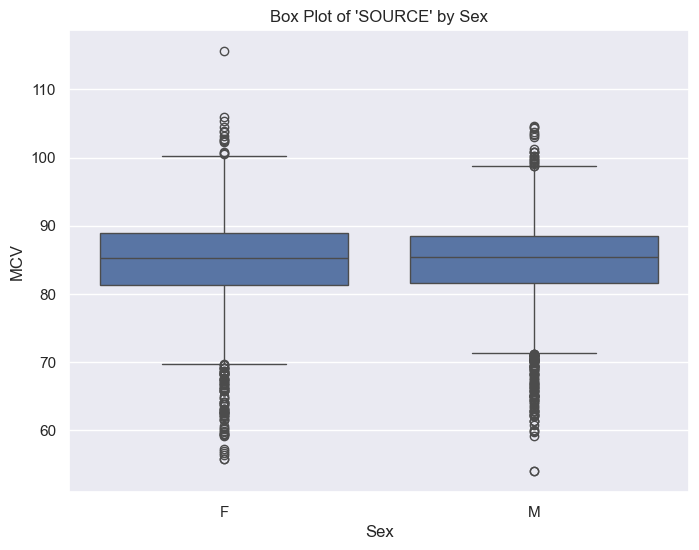

In [19]:
# Filter data by sex
data_female = data[data['SEX'] == 'F']
data_male = data[data['SEX'] == 'M']

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='SEX', y='MCV', data=data)
plt.title("Box Plot of 'SOURCE' by Sex")
plt.xlabel("Sex")
plt.ylabel("MCV")
plt.show()

F-value: The F-value is approximately 0.000303. This value indicates the ratio of the variance between the groups (in this case, between females and males) to the variance within the groups. A small F-value suggests that the variation between group means is similar to the variation within each group.  

P-value: The P-value is approximately 0.9861. This value represents the probability of observing the data if the null hypothesis were true. In this context, a high P-value suggests that there is no statistically significant difference in the 'MCV' variable between females and males. Specifically, with a P-value of 0.9861, we fail to reject the null hypothesis at conventional significance levels (e.g., α = 0.05), indicating that there is insufficient evidence to conclude that there is a difference in 'MCV' between sexes.  

In summary, based on the results of the one-way ANOVA test, there is no statistically significant difference in the 'MCV' variable between females and males.

In [20]:
# Perform One-Way ANOVA
f_value, p_value = stats.f_oneway(
    data[data['SOURCE'] == 0]['MCV'],
    data[data['SOURCE'] == 1]['MCV']
)

print("F-value:", f_value)
print("P-value:", p_value)

F-value: 2.2385418290857237
P-value: 0.13467942454209506


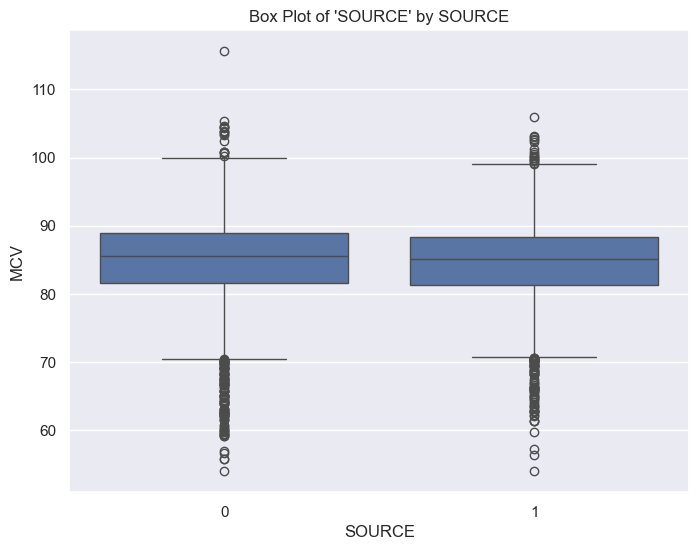

In [24]:
# Filter data by sex
data_0 = data[data['SOURCE'] == 0]
data_1 = data[data['SOURCE'] == 1]

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='SOURCE', y='MCV', data=data)
plt.title("Box Plot of 'SOURCE' by SOURCE")
plt.xlabel("SOURCE")
plt.ylabel("MCV")
plt.show()

F-value: The F-value obtained from the ANOVA test is approximately 2.239. This value represents the ratio of the variance between the groups ('SOURCE' = 0 and 'SOURCE' = 1) to the variance within the groups. A larger F-value suggests that the variation between group means is greater than the variation within each group.  

P-value: The P-value associated with the F-value is approximately 0.1347. This P-value indicates the probability of observing the data if the null hypothesis were true, which posits that there is no difference in 'MCV' between the two groups ('SOURCE' = 0 and 'SOURCE' = 1). In this case, a P-value of 0.1347 is higher than conventional significance levels (e.g., α = 0.05), suggesting that there is no statistically significant difference in 'MCV' between the two groups.  

In summary, based on the results of the one-way ANOVA test, there is no statistically significant difference in the 'MCV' variable between the two groups defined by the 'SOURCE' variable.

---
## Classification Model

Following the classification with each of these methods, we will then evaluate each of these models using the following metrics:
* **Accuracy**: Provide the overall number of correct predictions divided by the total number of predictions.
* **Confusion Matrix**: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
* **Precision**: A measure of a classifiers exactness.
* **Recall**: A measure of a classifiers completeness
* **F2 Score** (or F-score): A weighted average of precision and recall, with more importance to recall as we want to avoid false-negative errors more than false-positive errors.

## Training and Test Data Split

In [ ]:
## Train test split

# Feature set
X = data[features]
# Target set 
y = data['SOURCE']

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# train and test datasets dimensions
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3529, 12), (883, 12), (3529,), (883,))

In [ ]:
# Label Encding

# Encode binary classes for the 'M' and 'F' categorical values

X_train.SEX.replace({'F':0, 'M': 1}, inplace=True)
X_test.SEX.replace({'F':0, 'M': 1}, inplace=True)

# Feature Scaling

# Based on the distribution and outliers observed in the univariate analysis we can resort to 
# using a MinMaxScaler from sklearn

# minmax = MinMaxScaler(feature_range=(0,1))
scaler = MinMaxScaler(feature_range=(0,1))

X_train[num_feats] = scaler.fit_transform(X_train[num_feats]) #fit and transform the train set
X_test[num_feats] = scaler.transform(X_test[num_feats]) #transform the test test

### 1. Logistic Regression:

The basis for choosing logistic regression is mainly given the fact that the target variable is binary in nature and we can use the logistic regression as a base model to compare with the other models.

In [ ]:
logreg = LogisticRegression(random_state=42)

#Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
logreg_precision, logreg_recall, logreg_f2score, logreg_support = precision_recall_fscore_support(y_test, logreg.predict(X_test), beta=2)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
logreg_rocauc = roc_auc_score(y_test, logreg.predict(X_test))
logreg_confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

In [ ]:
print(f'---Metrics---\n accuracy: {logreg_accuracy*100:.0f}%\n precision: {logreg_precision}\n\
 recall: {logreg_recall}\n f2_score: {logreg_f2score}\n\
 ROC AUC Score: {logreg_rocauc:0.2f}\n\n\
 confusion matrix:\n {logreg_confusion_matrix}')

---Metrics---
 accuracy: 72%
 precision: [0.726094   0.70676692]
 recall: [0.85171103 0.52661064]
 f2_score: [0.82322675 0.55489965]
 ROC AUC Score: 0.69

 confusion matrix:
 [[448  78]
 [169 188]]


### 2. Support Vector Machine:

In [ ]:
svm =SVC(kernel='rbf', C=14, random_state=42)
svm.fit(X_train,y_train)

SVC(C=14, random_state=42)

In [ ]:
svm_precision, svm_recall, svm_f2score, svm_support = precision_recall_fscore_support(y_test, svm.predict(X_test), beta=2)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
svm_rocauc = roc_auc_score(y_test, svm.predict(X_test))
svm_confusion_matrix = confusion_matrix(y_test, svm.predict(X_test))

In [ ]:
print(f'---Metrics---\n accuracy: {svm_accuracy*100:.1f}%\n precision: {svm_precision}\n\
 recall: {svm_recall}\n f2_score: {svm_f2score}\n\
 ROC AUC Score: {svm_rocauc:0.2f}\n\n\
 confusion matrix:\n {svm_confusion_matrix}')

---Metrics---
 accuracy: 74.0%
 precision: [0.74342105 0.73090909]
 recall: [0.85931559 0.56302521]
 f2_score: [0.83333333 0.59013506]
 ROC AUC Score: 0.71

 confusion matrix:
 [[452  74]
 [156 201]]


### 3. K-Nearest Neighbor:

In [ ]:
# Training the K-NN model on the Training set
knn = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [ ]:
knn_precision, knn_recall, knn_f2score, knn_support = precision_recall_fscore_support(y_test, knn.predict(X_test), beta=2)
knn_accuracy = accuracy_score(y_test, knn.predict(X_test))
knn_rocauc = roc_auc_score(y_test, knn.predict(X_test))
knn_confusion_matrix = confusion_matrix(y_test, knn.predict(X_test))

In [ ]:
print(f'---Metrics---\n accuracy: {knn_accuracy*100:.1f}%\n precision: {knn_precision}\n\
 recall: {knn_recall}\n f2_score: {knn_f2score}\n\
 ROC AUC Score: {knn_rocauc:0.2f}\n\n\
 confusion matrix:\n {knn_confusion_matrix}')

---Metrics---
 accuracy: 72.1%
 precision: [0.73728814 0.6894198 ]
 recall: [0.8269962  0.56582633]
 f2_score: [0.80734967 0.5868681 ]
 ROC AUC Score: 0.70

 confusion matrix:
 [[435  91]
 [155 202]]


### 4. Random Forest:

In [ ]:
random_forest = RandomForestClassifier(n_estimators=40, random_state=42)

# Fit the model
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40, random_state=42)

In [ ]:
random_forest_precision, random_forest_recall, random_forest_f2score, random_forest_support = precision_recall_fscore_support(y_test, random_forest.predict(X_test), beta=2)
random_forest_accuracy = accuracy_score(y_test, random_forest.predict(X_test))
random_forest_rocauc = roc_auc_score(y_test, random_forest.predict(X_test))
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest.predict(X_test))

In [ ]:
print(f'---Metrics---\n accuracy: {random_forest_accuracy*100:.1f}%\n precision: {random_forest_precision}\n\
 recall: {random_forest_recall}\n f2_score: {random_forest_f2score}\n\
 ROC AUC Score: {random_forest_rocauc:0.2f}\n\n\
 confusion matrix:\n {random_forest_confusion_matrix}')

---Metrics---
 accuracy: 73.7%
 precision: [0.75085324 0.71043771]
 recall: [0.8365019  0.59103641]
 f2_score: [0.81784387 0.6115942 ]
 ROC AUC Score: 0.71

 confusion matrix:
 [[440  86]
 [146 211]]


---
## Model Optimization 

Based the performance of the models the following models selected for optimization are:



### a. Support Vector Machine:

In [ ]:
# Hyperparameters
param_grid = {'C': [1, 5, 10, 20, 40, 50, 100],
              'kernel': ['rbf'],
              'degree':[1, 2, 4, 6]
             } 

# Random search for best hyperparameters
search = GridSearchCV(SVC(random_state=42),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1)

search.fit(X_train, y_train)

# Best parameters for Support vector classifier
search.best_params_

best_svc = search.best_estimator_

Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [ ]:
# Fit the model
best_svc.fit(X_train, y_train)

svm_precision_opt, svm_recall_opt, svm_f2score_opt, svm_support_opt = precision_recall_fscore_support(y_test, best_svc.predict(X_test), beta=2)
svm_accuracy_opt = accuracy_score(y_test, best_svc.predict(X_test))


print(f'---Metrics---\n accuracy: {svm_accuracy_opt*100:.1f}%\n precision: {svm_precision_opt}\n\
 recall: {svm_recall_opt}\n f2_score: {svm_f2score_opt}')

---Metrics---
 accuracy: 74.0%
 precision: [0.74342105 0.73090909]
 recall: [0.85931559 0.56302521]
 f2_score: [0.83333333 0.59013506]


In [ ]:
best_svc

SVC(C=20, degree=1, random_state=42)

### b. K-Nearest Neighbor:

In [ ]:
# GRID SEARCH
# Define the parameter values that should be searched
param_grid = {'n_neighbors': [5, 7],
              'metric': ['cosine'],
              'weights': ['distance'],
              'algorithm': ['auto'],
              'leaf_size': [10]}

# Create a base model
knn = KNeighborsClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best parameters
print(grid_search.best_params_)

# Use the best estimator for our predictions on test
best_knn = grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}


In [ ]:
# Fit the model
best_knn.fit(X_train, y_train)

knn_precision_opt, knn_recall_opt, knn_f2score_opt, knn_support_opt = precision_recall_fscore_support(y_test, best_knn.predict(X_test), beta=2)
knn_accuracy_opt = accuracy_score(y_test, best_knn.predict(X_test))


print(f'---Metrics---\n accuracy: {knn_accuracy_opt*100:.1f}%\n precision: {knn_precision_opt}\n\
 recall: {knn_recall_opt}\n f2_score: {knn_f2score_opt}')

---Metrics---
 accuracy: 71.2%
 precision: [0.74113475 0.66144201]
 recall: [0.79467681 0.59103641]
 f2_score: [0.78335832 0.60389239]


### c. Random Forest Classifier:

In [ ]:
# Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 350, 500],  # More options for number of trees
#     'max_features': ['sqrt', 'log2'],      # Two types of features to consider
#     'criterion': ['gini', 'entropy', 'log_loss'],  # Tree split criteria
#     'min_samples_leaf': [1, 2, 4],         # Minimum number of samples at leaf node
#     'min_samples_split': [2, 5, 7],        # Minimum number of samples to split
#     'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
#     'bootstrap': [True, False]             # Whether bootstrap samples are used
# }
param_grid = {'n_estimators': [350], 
              'max_features': ['log2'],
              'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_leaf': [1],
             'min_samples_split': [7],
              'max_depth' : [None],
             'bootstrap': [False]}

# Create a base model
random_forest = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(random_forest, param_grid, cv=3, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best parameters
print(grid_search.best_params_)

# You can now use the best estimator for further predictions
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 350}


In [ ]:
# Fit the model
best_rf.fit(X_train, y_train)

random_forest_precision_opt, random_forest_recall_opt, random_forest_f2score_opt, random_forest_support_opt = precision_recall_fscore_support(y_test, best_rf.predict(X_test), beta=2)
random_forest_accuracy_opt = accuracy_score(y_test, best_rf.predict(X_test))

print(f'---Metrics---\n accuracy: {random_forest_accuracy_opt*100:.1f}%\n precision: {random_forest_precision_opt}\n\
 recall: {random_forest_recall_opt}\n f2_score: {random_forest_f2score_opt}')

---Metrics---
 accuracy: 74.4%
 precision: [0.75951557 0.7147541 ]
 recall: [0.83460076 0.61064426]
 f2_score: [0.81841909 0.62896711]


#### Feature Importance

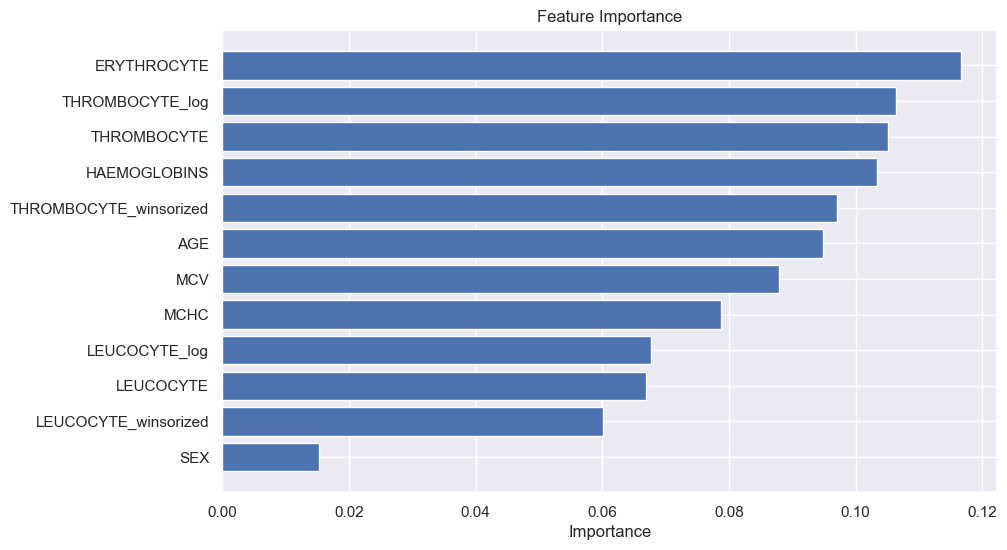

In [ ]:
best_rf_feature_importance = pd.DataFrame({'features': best_rf.feature_names_in_, 'importance': best_rf.feature_importances_})
best_rf_feature_importance.sort_values(
    by='importance', 
    ascending=True, 
    inplace=True
)
plt.figure(figsize=(10, 6))
plt.barh(best_rf_feature_importance['features'], best_rf_feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn import tree

# Extract one of the trees from the forest
chosen_tree = best_rf.estimators_[0]

# Set the figure size
plt.figure(figsize=(20,10))

# Plot the decision tree
tree.plot_tree(chosen_tree, 
               filled=True, 
               feature_names=best_rf.feature_names_in_, 
               class_names=best_rf.classes_.astype(str),
               rounded=True,
               fontsize=10)
plt.show()

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got array(['HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCHC',
       'MCV', 'AGE', 'SEX', 'LEUCOCYTE_log', 'LEUCOCYTE_winsorized',
       'THROMBOCYTE_log', 'THROMBOCYTE_winsorized'], dtype=object) instead.

<Figure size 2000x1000 with 0 Axes>

---
## Results

In [ ]:
# Create a function to plot confusion matrix and classification metrics
def plot_cm(cm, precision, recall, f2score, accuracy, title):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.subplot(1, 2, 2)
    metrics = [precision, recall, f2score, accuracy]
    metric_names = ['Precision', 'Recall', 'F2 Score', 'Accuracy']
    sns.barplot(x=metric_names, y=metrics)
    plt.ylim(0, 1)
    
    plt.suptitle(title, size = 15)

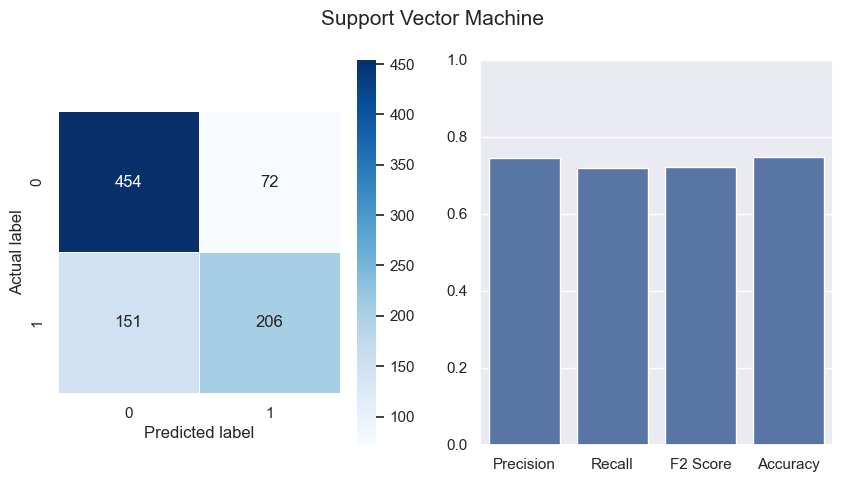

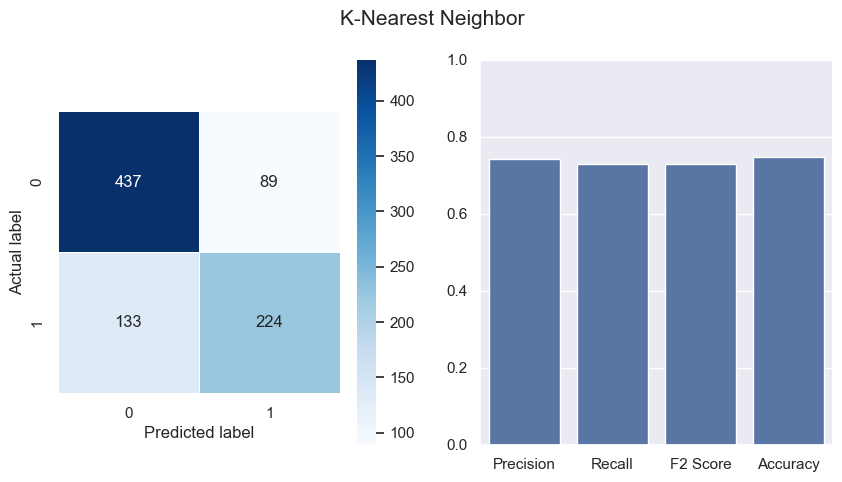

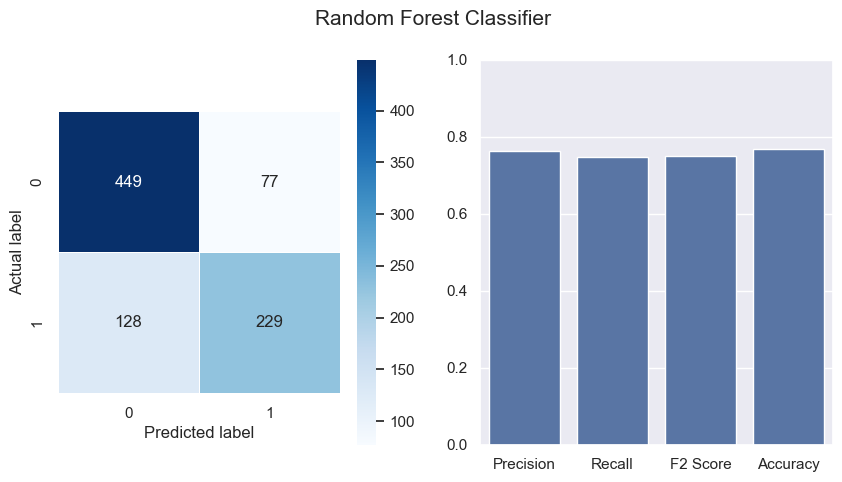

In [ ]:
# Compute average metrics
svm_precision_opt_avg = np.mean(svm_precision_opt)
svm_recall_opt_avg = np.mean(svm_recall_opt)
svm_f2score_opt_avg = np.mean(svm_f2score_opt)

knn_precision_opt_avg = np.mean(knn_precision_opt)
knn_recall_opt_avg = np.mean(knn_recall_opt)
knn_f2score_opt_avg = np.mean(knn_f2score_opt)

random_forest_precision_opt_avg = np.mean(random_forest_precision_opt)
random_forest_recall_opt_avg = np.mean(random_forest_recall_opt)
random_forest_f2score_opt_avg = np.mean(random_forest_f2score_opt)

# Compute confusion matrices
cm_svm = confusion_matrix(y_test, best_svc.predict(X_test))
cm_knn = confusion_matrix(y_test, best_knn.predict(X_test))
cm_rf = confusion_matrix(y_test, best_rf.predict(X_test))

# Plot confusion matrices and classification metrics
plot_cm(cm_svm, svm_precision_opt_avg, svm_recall_opt_avg, svm_f2score_opt_avg, svm_accuracy_opt, 'Support Vector Machine')
plot_cm(cm_knn, knn_precision_opt_avg, knn_recall_opt_avg, knn_f2score_opt_avg, knn_accuracy_opt, 'K-Nearest Neighbor')
plot_cm(cm_rf, random_forest_precision_opt_avg, random_forest_recall_opt_avg, random_forest_f2score_opt_avg, random_forest_accuracy_opt, 'Random Forest Classifier')


In [ ]:
y_test_pred = best_svc.predict(X_test)
y_test_pred = pd.DataFrame({'predicted' : y_test_pred})
X_test.reset_index(drop=True, inplace=True)
X_y_test_pred = pd.concat([X_test, y_test_pred], axis=1)
X_y_test_pred.head()

,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCHC,MCV,AGE,SEX,predicted
0,0.754967,0.625392,0.079470,0.200851,0.538462,0.488636,0.489796,1,0
1,0.701987,0.620690,0.033113,0.221277,0.600000,0.394481,0.102041,1,0
2,0.403974,0.297806,0.133775,0.232340,0.638462,0.511364,0.663265,1,1
3,0.245033,0.155172,0.119205,0.050213,0.661538,0.550325,0.765306,1,1
4,0.668874,0.500000,0.066225,0.205106,0.700000,0.500000,0.244898,0,0


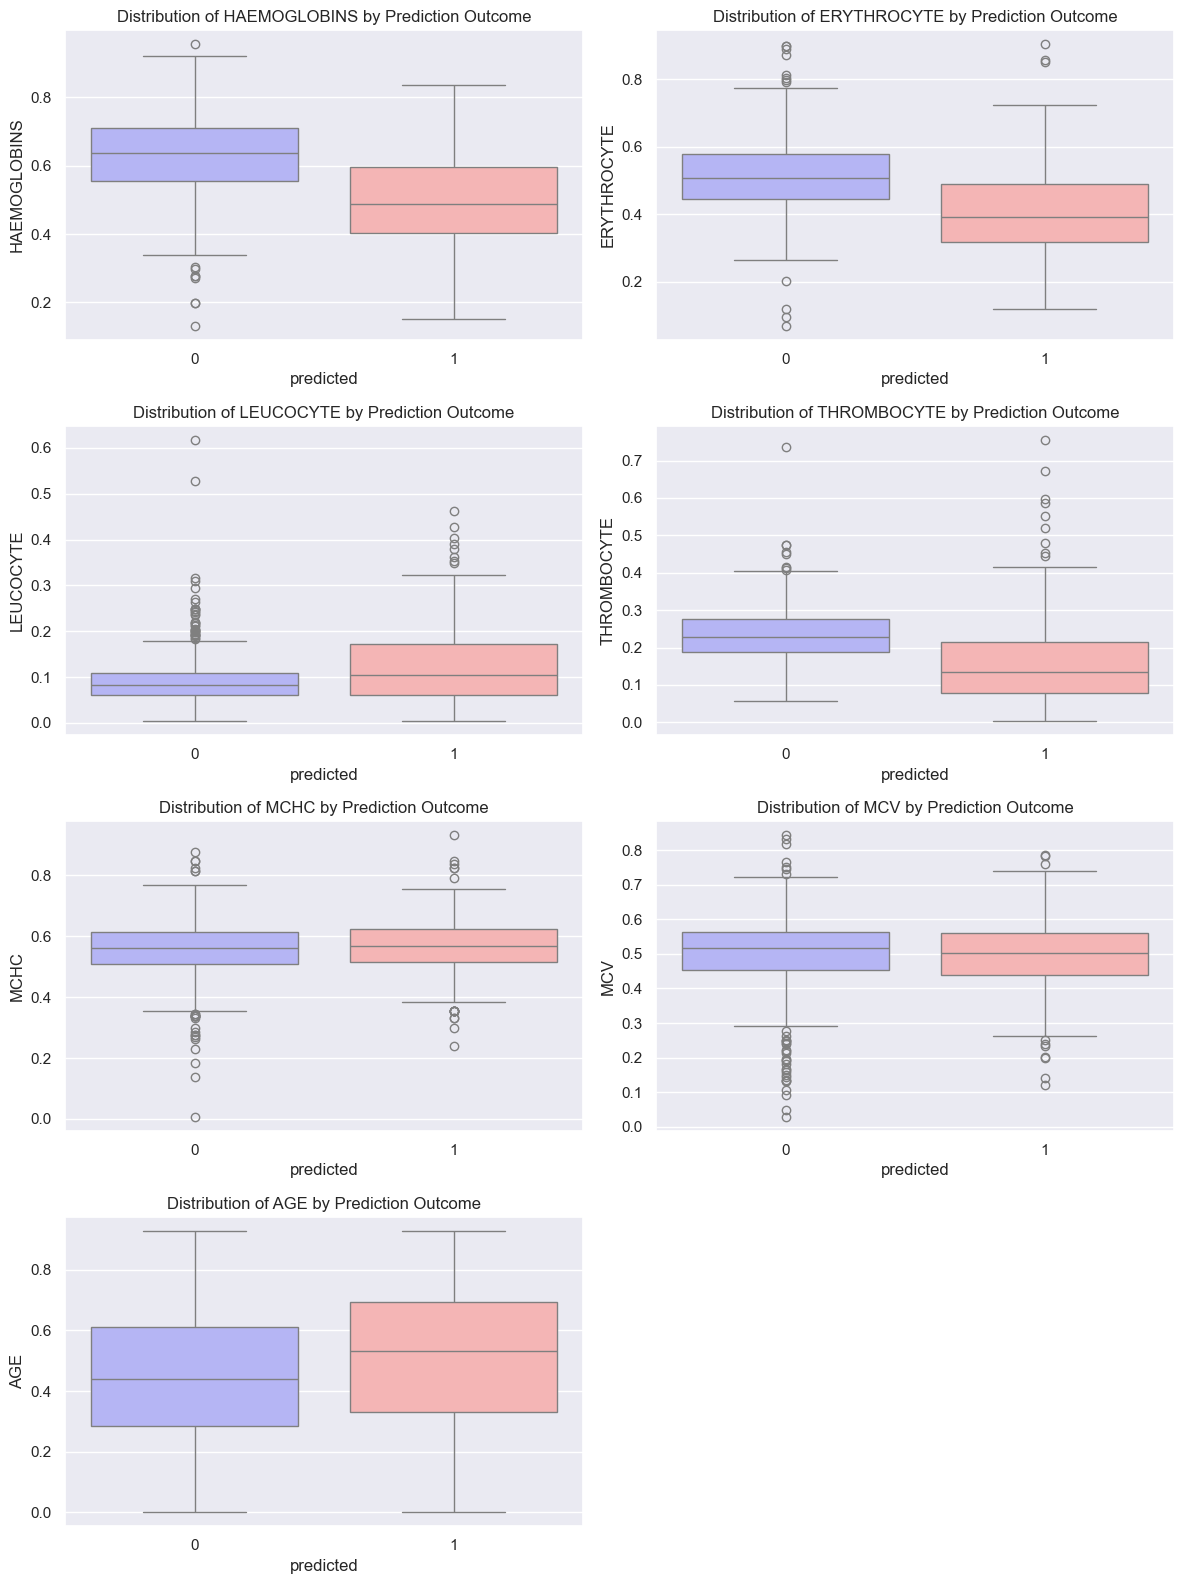

In [ ]:
# Setting up the figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))  # Adjust the figsize to fit your display
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Box Plots for each feature
features = ['HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCHC', 'MCV', 'AGE']
for i, feature in enumerate(features):
    sns.boxplot(x='predicted', y=feature, data=X_y_test_pred, palette='bwr', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Prediction Outcome')

# If there's an empty subplot, hide it
if len(axes) > len(features):
    for ax in axes[len(features):]:
        ax.axis('off')

plt.tight_layout()
plt.show()

From the plots, we could see from the prediction that:

1. Haemoglobins (Protein containing iron that facilitates the transport of oxygen in red blood cells) and Erythrocyte (Red blood cell): The patients who are admitted as in-patients tend to have lower Haemoglobins and Erythrocyte because of
   - Increased Severity of Underlying Conditions: Low hemoglobin often signals severe or uncontrolled disease states, such as advanced kidney disease or cancers, which require intensive management and monitoring.
   - Complications of Anemia: Severe anemia can lead to significant complications requiring hospitalization, such as heart problems (like heart failure), severe fatigue, and other organ dysfunctions due to poor oxygenation.
   - Acute and Chronic Complications: With fewer red blood cells to transport oxygen, critical organs and tissues do not receive the oxygen they need, which can lead to complications such as organ failure, severe weakness, and in some cases, life-threatening conditions that necessitate immediate hospital care.

2. With the same reasons as above, We could see that the patients who are admitted as in-patients tend to have slightly lower MCHC (Mean Corpuscular Hemoglobin Concentration, Represents the average concentration of hemoglobin within red blood cells) and 
MCV (Mean Corpuscular Volume or the average size of red blood cells)

3. Thrombocyte (Blood clotting palette): The patients who are admitted as in-patients tend to have lower Thrombocyte because of
   - Increased Bleeding Risk: The primary function of thrombocytes (platelets) is to help blood clot. A low platelet count can lead to easy or excessive bleeding, which might not stop on its own after an injury or surgery. This condition can manifest as frequent nosebleeds, gum bleeding, heavy menstrual periods, or severe bruising. In some cases, internal bleeding can occur, which can be life-threatening and requires immediate medical attention.

4. However, the patients who are admitted as in-patients tend to have higher Leucocyte (White blood cell) because:
   - Increased Risk of Thrombosis: One of the main risks associated with high thrombocyte counts is an increased likelihood of developing blood clots (thrombosis). These clots can form in arteries or veins and may lead to serious conditions such as deep vein thrombosis, pulmonary embolism, or stroke, depending on where the clot forms. Such events often require immediate hospital care.
   - Underlying Health Conditions: Secondary thrombocytosis can be a response to another condition, such as inflammation, infection, cancer, or anemia. Identifying and managing these underlying conditions often necessitates detailed evaluation and treatment in a hospital setting. Primary thrombocytosis, often due to a myeloproliferative disorder, requires careful monitoring and management to prevent complications.

5. Lastly, older-aged patients have a higher chance of being admitted.

- 1: In-patient
- 0: Out-patient

---

### Interpreting the results:

* In terms of accuracy i.e., the overall number of correct predictions, Random Forest shows a clear superiority with 76.8% followed by KNN with 74.9% and SVM with 74.7%.

* Using the F2 score that bears more weight to the recall which shows the percentange of relevant data points correctly classified by the models, we again see Random Forest clearly win over KNN and SVM. Howevewr, SVM performs slightly better in predicting the out patient data (0.83) while KNN performs better in predicting the in patient data (0.64) between the two.


---
## Discussion

The random forest is a sutiable model to aid in the patient classification task of patients to be admitted to the in patient and out patient units based on the electronic health records porvided. The features chosen after dropping the Haematocrit and MCH values still provided a valuable classification result.

However, there is further scope to improve with potentially a larger collection of patient records as well as further investigation of the dataset using factor analysis or other methods that can help reduce the dimensionality of the feature set. 

# Visualization